# Uncertainty quantification with Conformal Prediction
> Tutorial on how to train neuralforecast models and obtain prediction intervals using the conformal prediction methods

Conformal prediction uses cross-validation on a model trained with a point loss function to generate prediction intervals. No additional training is needed, and the model is treated as a black box. The approach is compatible with any model.

In this notebook, we demonstrate how to obtain prediction intervals using conformal prediction.

## Load libraries

In [ ]:
import logging

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import NHITS
from neuralforecast.utils import AirPassengersPanel
from neuralforecast.utils import PredictionIntervals
from neuralforecast.losses.pytorch import DistributionLoss, MAE

In [ ]:
logging.getLogger('pytorch_lightning').setLevel(logging.ERROR)

## Data

We use the AirPassengers dataset for the demonstration of conformal prediction.


In [ ]:
AirPassengersPanel_train = AirPassengersPanel[AirPassengersPanel['ds'] < AirPassengersPanel['ds'].values[-12]].reset_index(drop=True)
AirPassengersPanel_test = AirPassengersPanel[AirPassengersPanel['ds'] >= AirPassengersPanel['ds'].values[-12]].reset_index(drop=True)
AirPassengersPanel_test['y'] = np.nan
AirPassengersPanel_test['y_[lag12]'] = np.nan

## Model training

We now train a NHITS model on the above dataset. To support conformal predictions, we must first instantiate the `PredictionIntervals` class and pass this to the `fit` method. By default, `PredictionIntervals` class employs `n_windows=2` for the corss-validation during the computation of conformity scores. We also train a MLP model using DistributionLoss to demonstate the difference between conformal prediction and quantiled outputs. 

By default, `PredictionIntervals` class employs `method=conformal_distribution` for the conformal predictions, but it also supports `method=conformal_error`. The `conformal_distribution` method calculates forecast paths using the absolute errors and based on them calculates quantiles. The `conformal_error` method calculates quantiles directly from errors.

We consider two models below:

1. A model trained using a point loss function (`MAE`), where we quantify the uncertainty using conformal prediction. This case is labeled with `NHITS`.
2. A model trained using a `DistributionLoss('Normal')`, where we quantify the uncertainty by training the model to fit the parameters of a Normal distribution. This case is labeled with `NHITS1`.


In [ ]:
horizon = 12
input_size = 24

prediction_intervals = PredictionIntervals()

models = [NHITS(h=horizon, input_size=input_size, max_steps=100, loss=MAE(), scaler_type="robust"), 
          NHITS(h=horizon, input_size=input_size, max_steps=100, loss=DistributionLoss("Normal", level=[90]), scaler_type="robust")]
nf = NeuralForecast(models=models, freq='ME')
nf.fit(AirPassengersPanel_train, prediction_intervals=prediction_intervals)

## Forecasting

To generate conformal intervals, we specify the desired levels in the `predict` method. 

In [ ]:
preds = nf.predict(futr_df=AirPassengersPanel_test, level=[90])

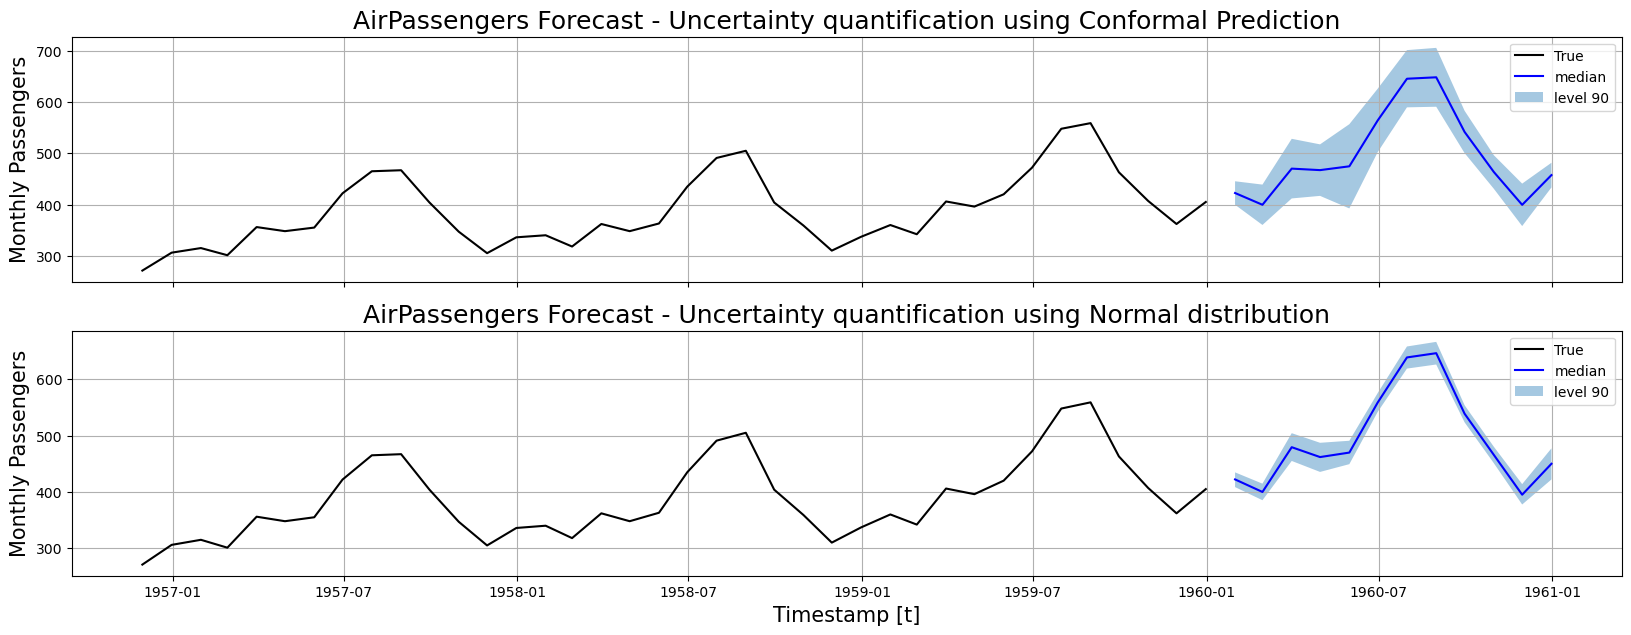

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (20, 7))
plot_df = pd.concat([AirPassengersPanel_train, preds])

plot_df = plot_df[plot_df['unique_id']=='Airline1'].drop(['unique_id','trend','y_[lag12]'], axis=1).iloc[-50:]

ax1.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
ax1.plot(plot_df['ds'], plot_df['NHITS'], c='blue', label='median')
ax1.fill_between(x=plot_df['ds'][-12:], 
                 y1=plot_df['NHITS-lo-90'][-12:].values,
                 y2=plot_df['NHITS-hi-90'][-12:].values,
                 alpha=0.4, label='level 90')
ax1.set_title('AirPassengers Forecast - Uncertainty quantification using Conformal Prediction', fontsize=18)
ax1.set_ylabel('Monthly Passengers', fontsize=15)
ax1.set_xticklabels([])
ax1.legend(prop={'size': 10})
ax1.grid()

ax2.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
ax2.plot(plot_df['ds'], plot_df['NHITS1'], c='blue', label='median')
ax2.fill_between(x=plot_df['ds'][-12:], 
                 y1=plot_df['NHITS1-lo-90'][-12:].values,
                 y2=plot_df['NHITS1-hi-90'][-12:].values,
                 alpha=0.4, label='level 90')
ax2.set_title('AirPassengers Forecast - Uncertainty quantification using Normal distribution', fontsize=18)
ax2.set_ylabel('Monthly Passengers', fontsize=15)
ax2.set_xlabel('Timestamp [t]', fontsize=15)
ax2.legend(prop={'size': 10})
ax2.grid()
